# NYC Airbnb Rental Prices Data Exploration

This notebook demonstrates a data exploration for the given sample [dataset](https://github.com/leolorenzoii/nd0821-c2-build-model-workflow-starter/tree/master/components/get_data/data) of rental prices in New York City.

## Dataset Information

The sample dataset is a subset of Kaggle's [New York City Airbnb Open Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) which is a dataset that describe the listings activity and metrics for the year 2019 in NYC. The dataset consist of `16` columns which we summarize using the table below:

| Column Name | Type | Description |
| ----------- | ---- | ----------- |
| `id` | int| Listing ID |
| `name` | str | Name of the listing |
| `host_id` | int | Unique ID of the host | 
| `host_name` | str | Name of the host |
| `neighbourhood_group` | str | Location of the listing |
| `neighbourhood` | str | Area of the listing |
| `latitude` | float | Latitude coordinates |
| `longitude` | float | Longitude coordinates |
| `room_type` | str | Listing space type |
| `price` | int | Price in dollars |
| `minimum_nights` | int | Minimum nights required by the listing |
| `number_of_reviews` | int | Number of reviews |
| `last_review` | date | Date of latest review |
| `reviews_per_month` | float | Number of reviews per month |
| `calculated_host_listings_count` | int | Amount of listing per host |
| `availability_365` | int | Number of days when listing is available for booking |

In our dataset, the `price` will be our target feature, while all the other can be used as predictors. Note however that columns such as `id` and `host_id` won't be useful for our model since they are mere `id`'s of each listing.

Furthermore, we observe that **most of the predictors are categorical** in nature, although some derived features such as `reviews_per_month` is numerical. Which imply that *information-based models* might work best for this dataset. Nonetheless, if computational capacity permits, we can also explore using other type of model such as *probabilistic* and *error-based* models during model experimentation.

## Loading the Dataset

Let us know proceed with loading the dataset. First, we import the relevant libraries.

In [1]:
import wandb
import pandas as pd

We then initialize our [Weights and Biases](https://wandb.ai/leolorenzoii/nyc_airbnb) run and retrieve the latest `sample.csv` artifact.

In [2]:
# Initialize weights and biases run then read data
run = wandb.init(project="nyc_airbnb", group="eda", save_code=True)
local_path = wandb.use_artifact("sample.csv:latest").file()
data = pd.read_csv(local_path)

wandb: Currently logged in as: leolorenzoii (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


The dataset is now loaded as the `data` variable. We can then proceed to perform data exploration on this dataset.

## Data Exploration

In this section, we proceed to get to know the data using off the shelf tools such as **Pandas Profiling** but also extract insights using custom plots.

### Data Types

Let us first look if the data types of the column align with the data dictionary.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20000 non-null  int64  
 1   name                            19993 non-null  object 
 2   host_id                         20000 non-null  int64  
 3   host_name                       19992 non-null  object 
 4   neighbourhood_group             20000 non-null  object 
 5   neighbourhood                   20000 non-null  object 
 6   latitude                        20000 non-null  float64
 7   longitude                       20000 non-null  float64
 8   room_type                       20000 non-null  object 
 9   price                           20000 non-null  int64  
 10  minimum_nights                  20000 non-null  int64  
 11  number_of_reviews               20000 non-null  int64  
 12  last_review                     

Here, we notice that `last_review` which was supposed to be in `datetime` format is in an `object` format instead.

### Pandas Profiling

Let us first look at the profile of the data using `pandas_profiling`. Note that the next cell imports this library and outputs the profile report as a widget in this notebook.

In [4]:
import pandas_profiling

# Create profile report of the dataset and print it to the notebook as widgets
profile = pandas_profiling.ProfileReport(data)
profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Overall, we have a total of `20,000` observations in the dataset, with `8,261` missing cells (comprising of `2.6%` of overall cells). There are `10` numerical features and `6` categorical features.

**Observations**:

*Warnings*

1. Features with *high cardinality* such as `name`, `host_name`, `neighbourhood`, and `last_review` are to be expected.
2. All cells with missing values are accounted from the `last_review` and `reviews_per_month` column. This might mean that the missing values are those listings that don't have any reviews. Which aligns with the number of `zeros` that `number_of_reviews` has.
3. Another interesting feature of the dataset is the `availability_365` variable, which has a lot of zeros as well. This weirdly imply that more that `35.9%` of the listings in the dataset are not available in any day, but can also mean that some may be on reservation only arrangement.

*Univariate Analysis*

1. The `neighbourhood_group` is distributed across `5` locations with imbalanceness. Most of the listings are found in `Manhattan` or `Brooklyn`.
2. The `neighbourhood` column has *high cardinality* which may be attributed to the number of possible areas in NYC. This can be a good thing, since when we one-hot encode this feature, we may be able to separate and discriminate according to which area of `neighbourhood` they belong.
3. The `room_type` also has an imbalanced distribution. It has `3` distinct values, with `Shared room` being very underrepresented.
4. The `price` feature has an exponential distribution, which imply the presence of *outliers*. In particular, we see values as high as `$10,000` which may imply very luxurious listings. These values may lead to poor performance for some models. As such, it is recommended that we perform clipping for these values. The recommended action is to consider only values within `$10` and `$350`.
5. The `minimum_nights` feature has *outliers* as well. In particular, we see values as high as `1250`, which may imply that those listings can be rented for several years. Nonetheless, the presence of these outliers may make our model perform poor on the dataset. We take note of this fact and investigate further on how to handle this outliers. One possible approach in handling this is by using *clamp transformation*. We can opt to transform too high values to the `95th` percentile which is `30`.
6. `number_of_reviews` and `reviews_per_month` both have an exponential distribution. Although tree-based models may be able to handle this behavior, we can also explore using log-normalization to handle outliers and possible make the distribution more normally distributed.

*Bivariate Analysis*

Although there isn't a striking pair of feature that exhibits a noticeable trend, here are some interesting observations:

1. `price` is negatively correlated with `longitude` which might imply that listings on the eastern part of the city is relatively pricier than those in the west.
2. From the interaction plot of `latitude` and `longitude`, we notice that there is a region where listings are mostly concentrated. Furthermore there are two hotspots that we can observe from the plot.

### Custom Plots

We further enrich our analysis by considering feature interactions that were not included in the profile report. These are mainly categorical to categorical interactions, categorical to numerical interactions, and a map plot of the listings.

#### Categorical to Categorical

Here, it would be interesting to see how the `room_type` is distributed among the `neighbourhood_group`. We visualize this interaction using a stacked bar plot from a function we defined in `utils` library.

/home/leolorenzoii/miniconda3/envs/mlflow-bf730317e4eab12284993ac5aec4af38a5483f88/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


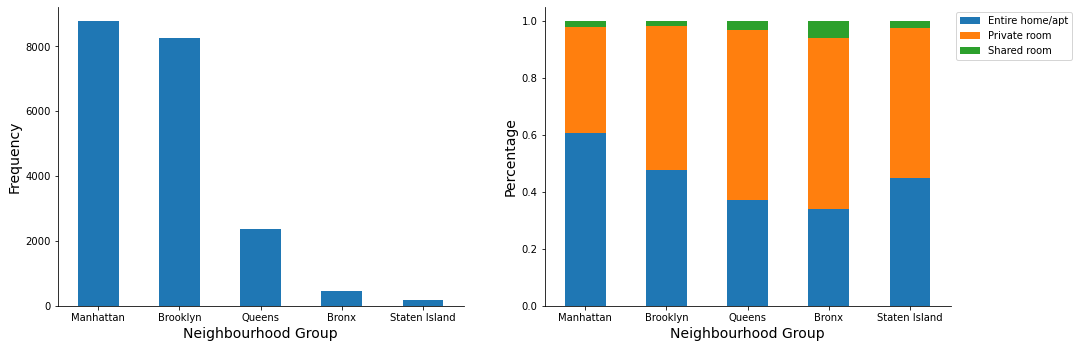

In [5]:
import utils

utils.categorical_categorical_plot(data, 'neighbourhood_group', 'room_type');

Here, we notice that `Manhattan` and `Brooklyn` have higher percentage of listings that allow for the entire home or apartment, as compared to the minority neighbourhood groups.

#### Categorical to Numerical

Now, let us look how categorical and numerical features interact in our dataset. In particular, we look how `price` varies with respect to `room_type` and `neighbourhood_group`.

Let's first look at how `room_type` and `price` vary.

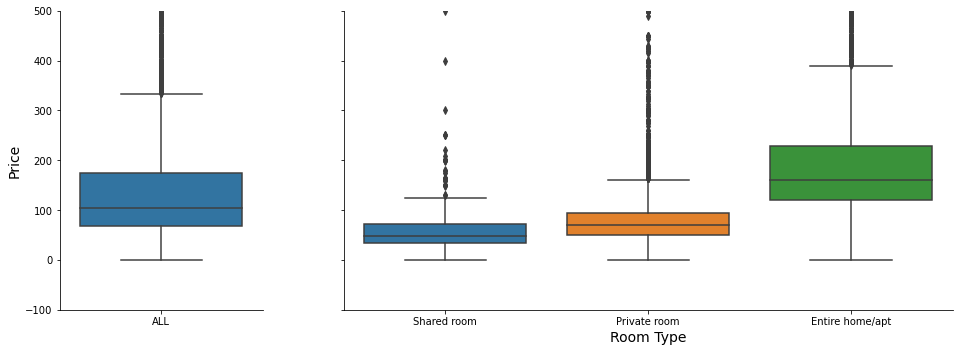

In [6]:
utils.categorical_numerical_plot(data, 'price', 'room_type', (-100, 500));

Unsurprisingly, renting an entire home or apartment will be significantly more expensive than renting a shared or private room. We can also see here that the outliers in our dataset occur across all the three room types.

Now let's look at how `price` vary across different `neighbourhood_group`.

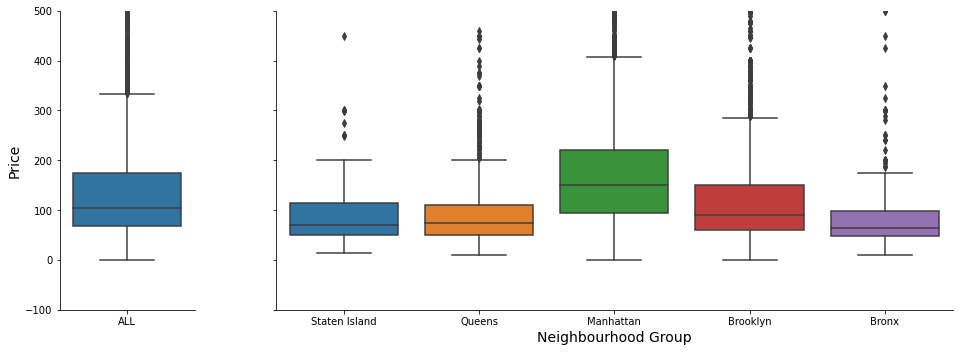

In [7]:
utils.categorical_numerical_plot(data, 'price', 'neighbourhood_group',
                                 (-100, 500));

Again, this result is not surprising. `Manhattan` has noticeably more expensive listings as compared to the other groups. `Brookyln` is the next cheaper option than `Manhattan`. The minority groups comprising of `Staten Island`, `Queens`, and `Bronx` have similar price ranges, but Staten Island has a noticeably fewer outliers.

#### Geographical Plots

Now, let us look at how the listings are distributed geographically. We briefly touch on this when we look at the interaction between `latitude` and `longitude` when we looked at the profile of the dataset. The following plots will enable us to visualize where exactly in the map are the listings distributed.

First, let us consider how the listings are concentrated on NYC.

In [8]:
utils.geographical_plot(data, 'latitude', 'longitude')

As we saw in the interaction plot in the profile report, there are two clusters of high density region of listing. The map reveals that these two are the Manhattan and Brooklyn neighborhoods. Zooming in further, in the map, we can see that they are further divided into four clusters: Upper and lower Manhattan, upper and lower Brooklyn.

Now let's look at how the price is distributed geographically.

In [9]:
utils.geographical_plot(data, 'latitude', 'longitude', 'price')

Unsurprisingly, the map shows exactly what we saw when we look at the interaction of `neighbourhood_group` and `price`. The Manhattan are has the most expensive listings. What is interesting in this plot is that the Brooklyn area has a lighter color as opposed to the previous visualization. Which may indicate that although Brooklyn also is dense in terms of number of listings, it may not be as that expensive than those listings in the Manhattan. 

## Data Preprocessing

We proceed in performing the recommended preprocessing step based on the information gathered during the Data Exploration step.

### Data Type Conversion

First, we deal with the mismatched data type that we identified during the exploration step.

In [10]:
data['last_review'] = pd.to_datetime(data['last_review'])

### Dropping of Outliers

Next, we drop outliers of the `price` column, only considering rows that is between `$10` and `$350`.

In [11]:
# Set minimum and maximum price
min_price = 10
max_price = 350

# Get rows that is between these two prices
idx = data['price'].between(min_price, max_price)
clean_data = data[idx].copy()

## Data Quality Verification

We then proceed to verify that our changes has been reflected in the cleaned data frame.

### Data type check

First, we look at the data types and number of non-null count for each column.

In [12]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19001 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              19001 non-null  int64         
 1   name                            18994 non-null  object        
 2   host_id                         19001 non-null  int64         
 3   host_name                       18993 non-null  object        
 4   neighbourhood_group             19001 non-null  object        
 5   neighbourhood                   19001 non-null  object        
 6   latitude                        19001 non-null  float64       
 7   longitude                       19001 non-null  float64       
 8   room_type                       19001 non-null  object        
 9   price                           19001 non-null  int64         
 10  minimum_nights                  19001 non-null  int64         
 11  nu

Here, notice that `reviews_per_month` is now correctly formatted as `datetime`.

### Clean Data Profile

Now let's look at the data profile of the cleaned data.

In [13]:
clean_data_profile = pandas_profiling.ProfileReport(clean_data)
clean_data_profile.to_widgets()

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Here, notice that the outliers for the `price` column has been correctly handled.

## Data Quality Plan

Finally, we present a summary of the important data quality issues that we saw in the dataset that *has been* or *needs to be handled* in the data preprocessing or pre-inference stage.

| Feature | Data Quality Issue | Potential Handling Strategies | Step/Point of Handling |
| ------- | ------------------ | ----------------------------- | ---------------------- |
| `last_review` | More than `20.6%` of the rows have missing values | Impute an arbitrary `date` value that corresponds to `no review` dates | Inference Pipeline | 
| `reviews_per_month` | More than `20.6%` of the rows have missing values | Impute a `zero` value which corresponds to no reviews per month | Inference Pipeline |
| `price` | Presence of outliers (high and low values) | Consider prices only at `$10$` to `$350` | Preprocess Pipeline |
| `minimum_nights` | Presence of outliers (high-values) | Clamp Transformation (1, 30) | Inference Pipeline |
| `number_of_reviews` | Presence of outliers | Log-normalization | Inference Pipeline |
| `reviews_per_month` | Presence of outliers | Log-normalization | Inference Pipeline |

In [14]:
# Finish the run
run.finish()